In [102]:
import os

import numpy as np
import wandb
import seaborn as sn

import utils
from naive_model import NaiveModel
from encoding import *

NUM_EMBEDDING = 2000

In [2]:
import torch

import torch.nn as nn
assert torch.cuda.is_available()

def to_device(d):
    if hasattr(d, 'cuda'):
        return d.cuda()
    return {k: v.cuda() for k, v in d.items()}

class Model(nn.Module):
    def __init__(self, units):
        super().__init__()
        self.units = units

        self.embed = nn.Embedding(num_embeddings=NUM_EMBEDDING, embedding_dim=units)
        self.lstm1 = nn.LSTM(input_size=units, hidden_size=units, num_layers=1, batch_first=True, bidirectional=True)

        self.binyan = nn.Linear(in_features=units, out_features=len(BINYAN))
        self.tense = nn.Linear(in_features=units, out_features=len(TENSE))
        self.voice = nn.Linear(in_features=units, out_features=len(VOICE))
        self.gender = nn.Linear(in_features=units, out_features=len(GENDER))
        self.plural = nn.Linear(in_features=units, out_features=len(PLURAL))

        self.r1 = nn.Linear(in_features=units, out_features=len(RADICALS))
        self.r2 = nn.Linear(in_features=units, out_features=len(RADICALS))
        self.r3 = nn.Linear(in_features=units, out_features=len(RADICALS))
        self.r4 = nn.Linear(in_features=units, out_features=len(RADICALS))

        self.features = {
            'B': self.binyan,
            'T': self.tense,
            'V': self.voice,
            'G': self.gender,
            'P': self.plural,

            'R1': self.r1,
            'R2': self.r2,
            'R3': self.r3,
            'R4': self.r4,
        }
        wandb.watch(self)

    def forward(self, x):
        embeds = self.embed(x)

        lstm_out, (h_n, c_n) = self.lstm1(embeds)
        left, right = torch.chunk(h_n, 2, dim=0)
        merge = torch.squeeze(left + right)

        outputs = { k: f(merge) for k, f in self.features.items() }
        return outputs


In [3]:

def sanity():
    model = create_model(100)
    with torch.no_grad():
        verbs = wordlist2numpy(["כשאתאקלם"])
        verbs = to_device(torch.from_numpy(verbs).to(torch.int64))
        tag_scores = model(verbs)
        for k in NAMES:
            print(k)
            v = nn.Softmax()(tag_scores[k]).cpu().detach().numpy()
            print(v)
            print(f'{np.mean(v)=}')
            print(f'{-np.log(1/len(v))=}')
            print()

# sanity()

In [4]:
import concrete

def load_dataset(file_pat):
    *features_train, verbs_train = concrete.load_dataset(f'{file_pat}_train.tsv')
    *features_test, verbs_test = concrete.load_dataset(f'{file_pat}_test.tsv')
    return ((wordlist2numpy(verbs_train), list_of_lists_to_category(features_train)),
            (wordlist2numpy(verbs_test), list_of_lists_to_category(features_test)))

def load_dataset_split(filename, split):
    *features_train, verbs_train = concrete.load_dataset(filename)
    features_test = [t[-split:] for t in features_train]
    verbs_test = verbs_train[-split:]
    del verbs_train[-split:]
    for t in features_train:
        del t[-split:]
    return ((wordlist2numpy(verbs_train), list_of_lists_to_category(features_train)),
            (wordlist2numpy(verbs_test ), list_of_lists_to_category(features_test )))


In [104]:
BATCH_SIZE = 64

def batch(a):
    ub = a.shape[0] // BATCH_SIZE * BATCH_SIZE
    return to_device(torch.from_numpy(a[:ub]).to(torch.int64)).split(BATCH_SIZE)

def batch_all_ys(ys):
    res = []
    m = {k: batch(ys[k]) for k in NAMES}
    nbatches = len(m['B'])
    for i in range(nbatches):
        res.append({k: m[k][i] for k in NAMES})
    return res

def fit(model, train, test, *, epochs,  runsize, criterion, optimizer, phases, teacher):
    x_train, y_train = train
    x_test, y_test = test
    data = {
        'train': (batch(x_train), batch_all_ys(y_train)),
        'test':  (batch(x_test ), batch_all_ys(y_test ))
    }

    stats = utils.Stats(runsize)
    
    for epoch in range(epochs):
        stats.epoch_start()
        
        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            stats.phase_start(phase, batches_in_phase=len(data[phase][0]))

            for inputs, labels in zip(*data[phase]):
                stats.batch_start()
                
                if phase == 'train':
                    outputs = model(inputs)
                else:
                    with torch.no_grad():
                        outputs = model(inputs)

                if teacher is not None:
                    pseudo_labels = teacher(inputs)
                    losses = {k: criterion(outputs[k].double(), pseudo_labels[k]) for k in outputs}
                else:
                    losses = {k: criterion(outputs[k].double(), labels[k]) for k in outputs}
                
                if phase == 'train' and isinstance(criterion, nn.CrossEntropyLoss):
                    stats.assert_resonable_initial(losses)
                
                loss = sum(losses.values())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                
                stats.update(loss=loss.item(),
                             batch_size=inputs.size(0),
                             d={k: (outputs[k], labels[k].detach()) for k in outputs})
                
                stats.batch_end()
            stats.phase_end()
        stats.epoch_end()
    return stats

@torch.no_grad()
def predict(model, *verbs):
    model.eval()
    verbs = wordlist2numpy(verbs)
    verbs = to_device(torch.from_numpy(verbs).to(torch.int64))
    outputs = model(verbs)
    res = {k: from_category(k, torch.argmax(v))
           for k, v in outputs.items()}
    res['R'] = ''.join(res[k] for k in ['R1', 'R2', 'R3', 'R4']).replace('.', '')
    return res
    

In [163]:
arity = '3'
gen = 'all'
artifact_name = f'{gen}_{arity}_shuffled'
filename = f'synthetic/{artifact_name}.tsv'  # all_verbs_shuffled
test_size = 5000

artifact = wandb.Artifact(artifact_name, type='dataset')
artifact.add_file(filename)

train, test = load_dataset_split(filename, split=test_size)

In [164]:
def naive_config(filename):
    return {
        'model': NaiveModel.learn_from_file(filename),
        'phases': ['test'],
        'criterion': nn.CrossEntropyLoss(),
        'optimizer': None
    }

def teacher_config(train):
    res = standard_config()
    res['teacher'] = NaiveModel.learn_from_data(train)
    res['criterion'] = nn.BCEWithLogitsLoss()  # BCELoss: works, but total loss is nan
    return res


def standard_config(units, lr):
    model = to_device(Model(units=units))
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    return {
        'model': model,
        'criterion': nn.CrossEntropyLoss(),
        'optimizer': optimizer,
        'phases': ['train', 'test'],
        'teacher': None
    }

In [206]:
os.environ['WANDB_MODE'] = 'dryrun'  # 'dryrun'

config = {
    'optimizer': 'adam',
    'batch_size': BATCH_SIZE,
    'epochs': 1,
    'runsize': 8192 // BATCH_SIZE,
    'test_size': test_size,
}
# group = f'lr_units_grid_search-{arity}-{wandb.util.generate_id()}'

def experiment(lr):
    units = 400

    config.update({
        'units': units,
        'lr': lr,
    })

    run = wandb.init(project="rootem",
                     # group=group,
                     name=f'{gen}-{arity}-{lr:.0e}',# f'{arity}-batch_{BATCH_SIZE}', # f'all-{arity}-lr_{lr:.0e}-units_{units}',
                     tags=[gen, arity, 'synthetic', 'shuffle', 'no_prefix'],
                     config=config)

    run.use_artifact(artifact)

    wandb.config.update(config, allow_val_change=True)

    print(config)
    stats = fit(train=train,
        test=test,
        epochs=config['epochs'],
        runsize=config['runsize'],
        **standard_config(config['units'], config['lr'])
    )
    wandb.save(f"simple_{arity}.h5")
    return stats

# lr = 8e-4, 10e-4, 20e-4, 30e-4, 40e-4, 50e-4, 60e-4]:
stats = experiment(lr=8e-4)

wandb: WARNING Using artifacts in dryrun mode is currently unsupported.


{'optimizer': 'adam', 'batch_size': 64, 'epochs': 1, 'runsize': 128, 'test_size': 5000, 'units': 400, 'lr': 0.0008}
 1 10880/10940 B_acc: 0.819 T_acc: 0.926 V_acc: 0.701 G_acc: 0.787 P_acc: 0.977 R1_acc: 0.973 R2_acc: 0.826 R3_acc: 1.000 R4_acc: 0.980 Loss: 1.9477
 1    78/   78 B_acc: 0.831 T_acc: 0.929 V_acc: 0.700 G_acc: 0.796 P_acc: 0.978 R1_acc: 0.969 R2_acc: 0.814 R3_acc: 1.000 R4_acc: 0.983 Loss: 1.9458


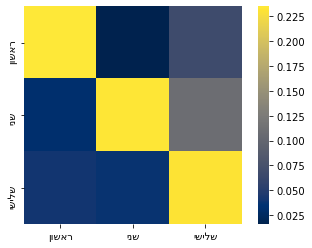

In [216]:
k = 'V'
labels = [x[::-1] for x in FEATURES[k]]
ax = sn.heatmap(stats.confusion[k], xticklabels=labels, yticklabels=labels, square=True, robust=True, cmap="cividis")

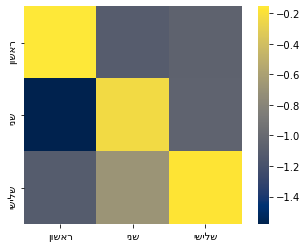

In [217]:
ax = sn.heatmap(stats.confusion_logprobs[k], xticklabels=labels, yticklabels=labels, square=True, robust=True, cmap="cividis")

In [ ]:
print(predict(model, 'סבסו'))
print(predict(model, 'מקדו'))
print(predict(model, 'נמזר'))
print(predict(model, 'כרדו'))

In [ ]:
print(predict(model, 'הבריל'))
print(predict(model, 'חגוו'))
print(predict(model, 'עגו'))
print(predict(model, 'צירלל'))

In [ ]:
print(predict(model, "השטקרפתי"))

In [ ]:
print(predict(model, "ישסו"))

In [205]:
import importlib
import encoding
import naive_model
import utils
encoding = importlib.reload(encoding)
naive_model = importlib.reload(naive_model)
utils = importlib.reload(utils)
wandb = importlib.reload(wandb)
Stats = utils.Stats
NaiveModel = naive_model.NaiveModel

In [114]:
import sklearn
labels = [x[::-1] for x in FEATURES['B']]
# wandb.plots.HeatMap(labels, labels, stats.confusion['B'])
help(wandb.plots.heatmap)

Help on module wandb.plots.heatmap in wandb.plots:

NAME
    wandb.plots.heatmap

FUNCTIONS
    heatmap(x_labels, y_labels, matrix_values, show_text=False)
        Generates a heatmap.
        
        Arguments:
         matrix_values (arr): 2D dataset of shape x_labels * y_labels, containing
                            heatmap values that can be coerced into an ndarray.
         x_labels  (list): Named labels for rows (x_axis).
         y_labels  (list): Named labels for columns (y_axis).
         show_text (bool): Show text values in heatmap cells.
        
        Returns:
         Nothing. To see plots, go to your W&B run page then expand the 'media' tab
               under 'auto visualizations'.
        
        Example:
         wandb.log({'heatmap': wandb.plots.HeatMap(x_labels, y_labels,
                    matrix_values)})

DATA
    chart_limit = 10000

FILE
    c:\users\elaza\appdata\local\programs\python\python38\lib\site-packages\wandb\plots\heatmap.py


